In [22]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import os
import seaborn as sns
from datetime import datetime
from textwrap import wrap
from matplotlib import ticker


%matplotlib inline

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

We are going to do time series analysis and forecasting for furniture sales.

In [4]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [41]:
#print(os.listdir('../data'))
df = pd.read_csv('../data/NumberConfirmedOfCases.csv', usecols=[1,2], engine='python')
#df['Date'] = df.apply(lambda x: datetime.strptime(x['Date'], '%Y-%m-%d').date(), axis=1) #convert the date
df = df.groupby('Date')['Cases'].sum().reset_index() #group the data
df.head()

,Date,Cases
0,2020-03-01,1
1,2020-03-12,1
2,2020-03-19,1
3,2020-03-23,1
4,2020-03-27,2


In [101]:
# load the dataset
d = df['Cases'].values.reshape(-1,1)
d = d.astype('float32')
#d

In [80]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 10))
#d.reshape(len(d),-1)
d = scaler.fit_transform(d)

## Split the data

In [102]:
# split into train and test sets
train_size = int(len(d) * 0.67)
test_size = len(d) - train_size
train, test = d[0:train_size,:], d[train_size:len(d),:]
print(len(train), len(test))

23 12


In [103]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [104]:
#create_dataset(d, look_back=1)

In [105]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [106]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [107]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 0s - loss: 260.5672
Epoch 2/100
 - 0s - loss: 260.1245
Epoch 3/100
 - 0s - loss: 259.6982
Epoch 4/100
 - 0s - loss: 259.2908
Epoch 5/100
 - 0s - loss: 258.8914
Epoch 6/100
 - 0s - loss: 258.5148
Epoch 7/100
 - 0s - loss: 258.1189
Epoch 8/100
 - 0s - loss: 257.7915
Epoch 9/100
 - 0s - loss: 257.4042
Epoch 10/100
 - 0s - loss: 257.0853
Epoch 11/100
 - 0s - loss: 256.7350
Epoch 12/100
 - 0s - loss: 256.4227
Epoch 13/100
 - 0s - loss: 256.0646
Epoch 14/100
 - 0s - loss: 255.7509
Epoch 15/100
 - 0s - loss: 255.4628
Epoch 16/100
 - 0s - loss: 255.1213
Epoch 17/100
 - 0s - loss: 254.7917
Epoch 18/100
 - 0s - loss: 254.4929
Epoch 19/100
 - 0s - loss: 254.2027
Epoch 20/100
 - 0s - loss: 253.8646
Epoch 21/100
 - 0s - loss: 253.5450
Epoch 22/100
 - 0s - loss: 253.2557
Epoch 23/100
 - 0s - loss: 252.9262
Epoch 24/100
 - 0s - loss: 252.5779
Epoch 25/100
 - 0s - loss: 252.2613
Epoch 26/100
 - 0s - loss: 251.8237
Epoch 27/100
 - 0s - loss: 251.4184
Epoch 28/100
 - 0s - loss: 250.9564
E

In [108]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 233.15 RMSE
Test Score: 1538.76 RMSE


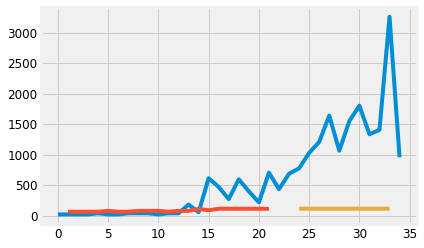

In [111]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(d)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(d)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(d)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(d))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [112]:
dataset = d

Epoch 1/100
 - 1s - loss: 0.0066
Epoch 2/100
 - 0s - loss: 0.0056
Epoch 3/100
 - 0s - loss: 0.0050
Epoch 4/100
 - 0s - loss: 0.0048
Epoch 5/100
 - 0s - loss: 0.0046
Epoch 6/100
 - 0s - loss: 0.0046
Epoch 7/100
 - 0s - loss: 0.0046
Epoch 8/100
 - 0s - loss: 0.0045
Epoch 9/100
 - 0s - loss: 0.0045
Epoch 10/100
 - 0s - loss: 0.0044
Epoch 11/100
 - 0s - loss: 0.0044
Epoch 12/100
 - 0s - loss: 0.0044
Epoch 13/100
 - 0s - loss: 0.0044
Epoch 14/100
 - 0s - loss: 0.0043
Epoch 15/100
 - 0s - loss: 0.0043
Epoch 16/100
 - 0s - loss: 0.0042
Epoch 17/100
 - 0s - loss: 0.0042
Epoch 18/100
 - 0s - loss: 0.0042
Epoch 19/100
 - 0s - loss: 0.0042
Epoch 20/100
 - 0s - loss: 0.0042
Epoch 21/100
 - 0s - loss: 0.0041
Epoch 22/100
 - 0s - loss: 0.0041
Epoch 23/100
 - 0s - loss: 0.0040
Epoch 24/100
 - 0s - loss: 0.0040
Epoch 25/100
 - 0s - loss: 0.0040
Epoch 26/100
 - 0s - loss: 0.0039
Epoch 27/100
 - 0s - loss: 0.0039
Epoch 28/100
 - 0s - loss: 0.0039
Epoch 29/100
 - 0s - loss: 0.0038
Epoch 30/100
 - 0s - lo

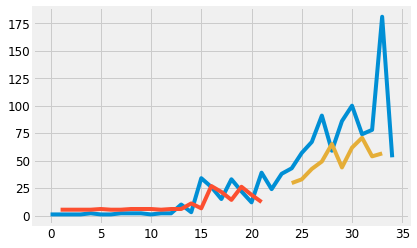

In [116]:
# LSTM for international airline passengers problem with time step regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)

# normalize the dataset
#scaler = MinMaxScaler(feature_range=(0, 1))
#dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [117]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# make a sample multivariable time series - not autoregressive
# generate a random walk
def random_walk(steps, scale = 1):
    w = np.zeros(steps)
    for x in range(1,steps):
        w[x] = w[x-1] + scale * np.random.normal()
    return(w)
        
time_steps = 5000
data = pd.DataFrame({'x' : range(time_steps), 
    'y' : np.arange(time_steps) ** (1/2) + random_walk(time_steps) })
data = data.assign(z = np.log(data.x+1) + 0.3 * data.y)
data_mat = np.array(data)

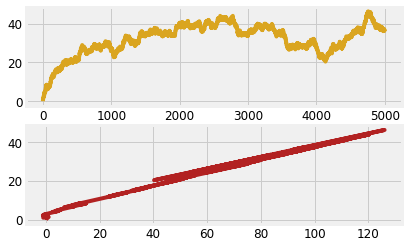

In [118]:
plt.subplot(2,1,1)
plt.plot(data_mat[:,0], data_mat[:,2], c = 'goldenrod')
plt.margins(0.05)
plt.subplot(2,1,2)
plt.plot(data_mat[:,1], data_mat[:,2], c = 'firebrick')
plt.margins(0.05)
plt.show()


Train on 3159 samples, validate on 790 samples
Epoch 1/50
 - 2s - loss: 2785.9333 - mse: 2785.9348 - val_loss: 315.3255 - val_mse: 315.3255
Epoch 2/50
 - 1s - loss: 269.4298 - mse: 269.4297 - val_loss: 358.9090 - val_mse: 358.9091
Epoch 3/50
 - 1s - loss: 213.6469 - mse: 213.6469 - val_loss: 292.9237 - val_mse: 292.9238
Epoch 4/50
 - 2s - loss: 175.9960 - mse: 175.9961 - val_loss: 158.7970 - val_mse: 158.7970
Epoch 5/50
 - 2s - loss: 134.5401 - mse: 134.5401 - val_loss: 100.0012 - val_mse: 100.0012
Epoch 6/50
 - 2s - loss: 90.9356 - mse: 90.9356 - val_loss: 94.5078 - val_mse: 94.5078
Epoch 7/50
 - 2s - loss: 91.9241 - mse: 91.9241 - val_loss: 74.4954 - val_mse: 74.4954
Epoch 8/50
 - 1s - loss: 68.4884 - mse: 68.4883 - val_loss: 48.1019 - val_mse: 48.1018
Epoch 9/50
 - 2s - loss: 67.2684 - mse: 67.2684 - val_loss: 49.1274 - val_mse: 49.1274
Epoch 10/50
 - 1s - loss: 69.4371 - mse: 69.4371 - val_loss: 30.6269 - val_mse: 30.6269
Epoch 11/50
 - 2s - loss: 60.8252 - mse: 60.8252 - val_loss:

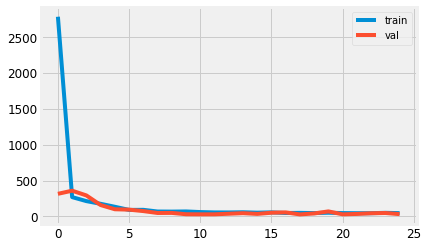

In [119]:

# split into samples (sliding time windows)
samples = list()
target = list()
length = 50

# step over the 5,000 in jumps of length
for i in range(time_steps - length - 1):
  # grab from i to i + length
    sample = data_mat[i:i+length,:2]
    outcome = data_mat[i+length+1,2]
    target.append(outcome)
    samples.append(sample)

# split out a test set
test_size = 1000
x_test_mat = np.dstack(samples[-test_size:])
x_test_3d_final = np.moveaxis(x_test_mat, [0, 1, 2], [1, 2, 0] )

# The RNN needs data with the format of [samples, time steps, features].
# Here, we have N samples, 50 time steps per sample, and 2 features
data_mat_stacked = np.dstack(samples[:-test_size])
data_mat_3d_final = np.moveaxis(data_mat_stacked, [0, 1, 2], [1, 2, 0] )

# and fix up the target
target_arr = np.array(target[:-test_size])

# now build the RNN
model = Sequential()
model.add(SimpleRNN(128, input_shape = (data_mat_3d_final.shape[1],
    data_mat_3d_final.shape[2]), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))

# monitor validation progress
early = EarlyStopping(monitor = "val_loss", mode = "min", patience = 7)
callbacks_list = [early]
    
model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mse'])

# and train the model
history = model.fit(data_mat_3d_final, target_arr, 
    epochs=50, batch_size=25, verbose=2, 
    validation_split = 0.20,
    callbacks = callbacks_list)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()


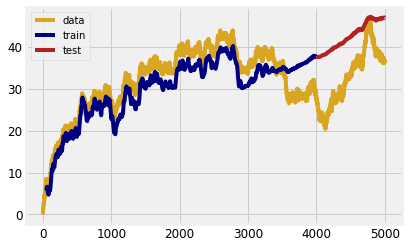

In [120]:
# get predictions
train_predictions = model.predict(data_mat_3d_final)
test_predictions = model.predict(x_test_3d_final)

# plot predictions vs actual
plt.plot(data['x'], 
    data['z'], c = 'goldenrod', label = 'data')
plt.plot(data.iloc[(length+1):-test_size]['x'], 
    train_predictions, c = 'navy', label = 'train')
plt.plot(data.iloc[-test_size:]['x'], 
    test_predictions, c = 'firebrick', label = 'test')
plt.legend(loc='best')
plt.show()
